<h2>Кепстральный анализ</h2>

Найдем кепстр последовательности единичных импульсов, повторяющихся с частотой 200 Гц, отфильтрованную КИХ-фильтром:

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [218]:
fs = 8000  # частота дискретизации
duration = 0.1  # длительность в секундах
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

f0 = 200
T0 = int(fs / f0)  # период в отсчетах

# Создаем импульсный источник
source_signal = np.zeros_like(t)
source_signal[::T0] = 1.0  # импульсы каждые T0 отсчетов

In [219]:
# ФНЧ
nyquist = fs / 2
cutoff_freq = 1000  # частота среза
b = signal.firwin(101, cutoff_freq / nyquist)  # КИХ-фильтр

# Свертка источника и фильтра
filtered_signal = signal.convolve(source_signal, b, mode='same')
filtered_signal = filtered_signal / np.max(np.abs(filtered_signal))  # нормировка

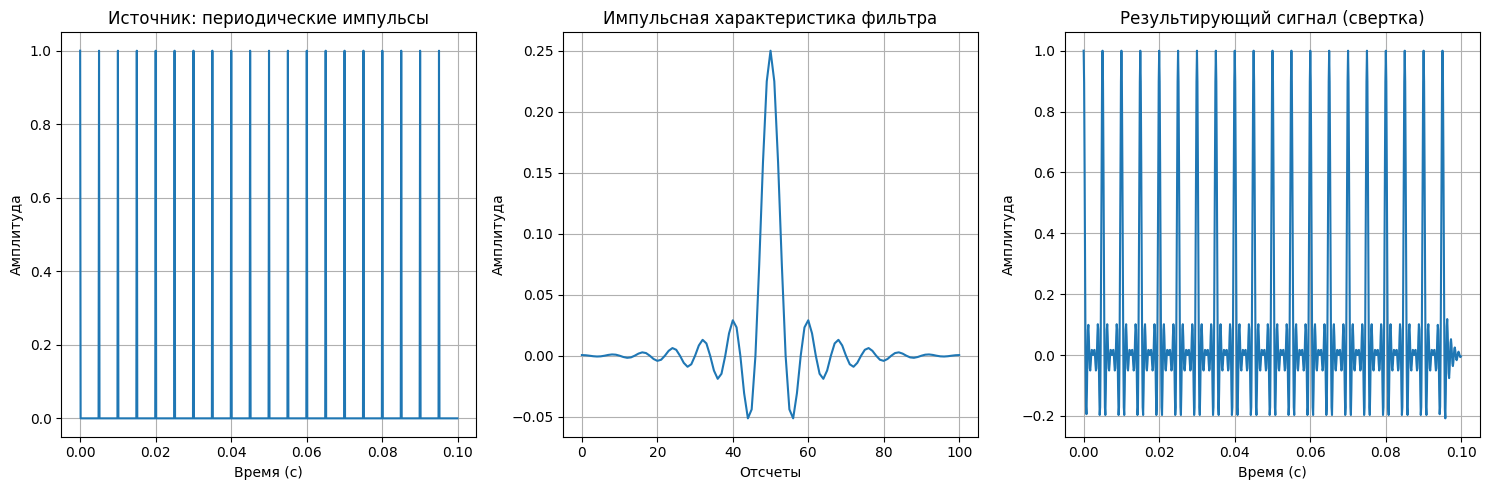

In [220]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(t[:1000], source_signal[:1000])
axes[0].set_title('Источник: периодические импульсы')
axes[0].set_xlabel('Время (с)')
axes[0].set_ylabel('Амплитуда')
axes[0].grid(True)

axes[1].plot(b)
axes[1].set_title('Импульсная характеристика фильтра')
axes[1].set_xlabel('Отсчеты')
axes[1].set_ylabel('Амплитуда')
axes[1].grid(True)

axes[2].plot(t[:1000], filtered_signal[:1000])
axes[2].set_title('Результирующий сигнал (свертка)')
axes[2].set_xlabel('Время (с)')
axes[2].set_ylabel('Амплитуда')
axes[2].grid(True)

plt.tight_layout()
plt.show()

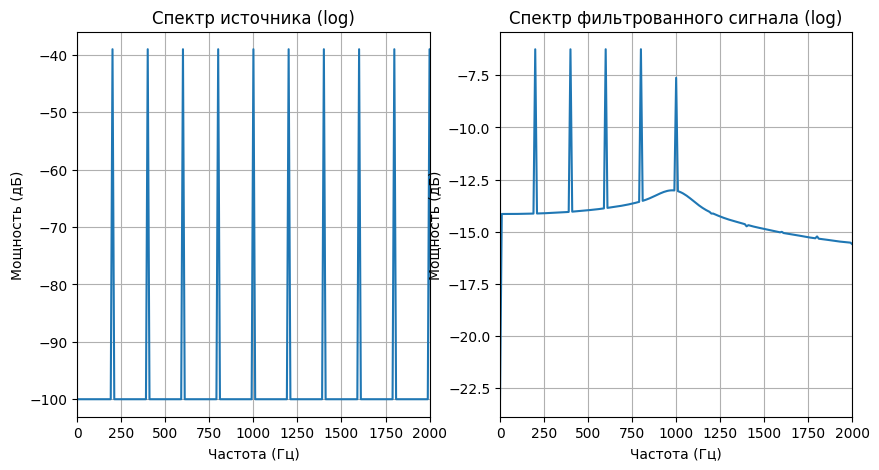

In [221]:
# Вычисление спектров
frequencies, source_spectrum = signal.periodogram(source_signal, fs)
frequencies, filtered_spectrum = signal.periodogram(filtered_signal, fs)
log_filtered_spectrum = np.log(filtered_spectrum + 1e-10)  # логарифм с защитой от 0

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Визуализация спектров
axes[0].plot(frequencies, 10 * np.log10(source_spectrum + 1e-10))
axes[0].set_title('Спектр источника (log)')
axes[0].set_xlabel('Частота (Гц)')
axes[0].set_ylabel('Мощность (дБ)')
axes[0].set_xlim(0, 2000)
axes[0].grid(True)

axes[1].plot(frequencies, log_filtered_spectrum)
axes[1].set_title('Спектр фильтрованного сигнала (log)')
axes[1].set_xlabel('Частота (Гц)')
axes[1].set_ylabel('Мощность (дБ)')
axes[1].set_xlim(0, 2000)
axes[1].grid(True)

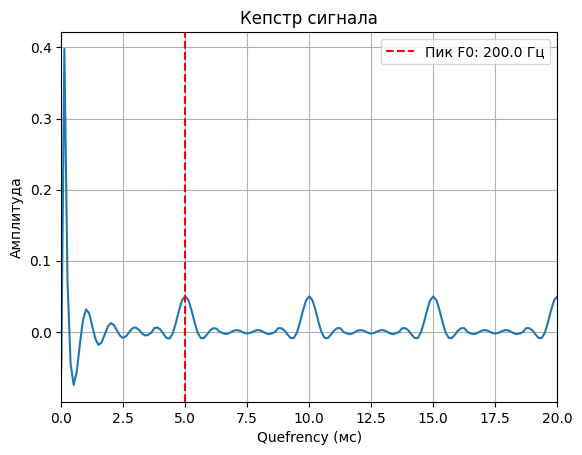

In [222]:
# Вычисление кепстра (через БПФ → логарифм → ОБПФ)
def compute_cepstrum(signal_data):
    spectrum = np.fft.fft(signal_data)
    log_spectrum = np.log(np.abs(spectrum) + 1e-10)
    cepstrum = np.real(np.fft.ifft(log_spectrum))
    return cepstrum

cepstrum = compute_cepstrum(filtered_signal)
quefrency = np.arange(len(cepstrum)) / fs  # ось quefrency в секундах

# Визуализация кепстра
plt.plot(quefrency * 1000, cepstrum)  # в миллисекундах
plt.title('Кепстр сигнала')
plt.xlabel('Quefrency (мс)')
plt.ylabel('Амплитуда')
plt.xlim(0, 20)
plt.grid(True)

# Определение F0 по кепстру
search_range = int(0.002 * fs), int(0.02 * fs)  # поиск от 2 до 20 мс
cepstrum_search = cepstrum[search_range[0]:search_range[1]]
max_peak_idx = np.argmax(np.abs(cepstrum_search)) + search_range[0]
f0_estimated = 1 / (quefrency[max_peak_idx])

plt.axvline(quefrency[max_peak_idx] * 1000, color='red', linestyle='--',
                   label=f'Пик F0: {f0_estimated:.1f} Гц')
plt.legend()

Попробуем построить кепстр реального сигнала, обработав его небольшими окнами, на которых ЧОТ будет предполагаться постоянной:

In [223]:
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft, ifft, irfft, fftfreq, rfftfreq

In [224]:
# генерируем перекрывающиеся интервалы, R - коэффициент перекрытия
def create_overlapping_chunks(x, w, R = 0.1):
    n = len(x)
    n_wind = len(w)
    step = math.floor(n_wind * (1 - R))
    nb = math.floor((n - n_wind) / step) + 1

    chunks = np.zeros((nb, n_wind))

    for i in range(nb):
        offset = i * step
        chunks[i, :] = w * x[offset : n_wind + offset]

    return chunks

In [225]:
def compute_voice_cepstrum(sig, sample_rate):
    cepstrum = compute_cepstrum(sig)
    quefrencies = np.array(range(len(sig)))/sample_rate

    # Отфильтруем значения под диапазон ЧОТ

    # самая высокая частота
    period_lb = 1/400
    # самая низкая
    period_ub = 1/50

    cepstrum_filtered = []
    quefrencies_filtered = []
    for i, quefrency in enumerate(quefrencies):
        if quefrency < period_lb or quefrency > period_ub:
            continue

        quefrencies_filtered.append(quefrency)
        cepstrum_filtered.append(cepstrum[i])

    return (quefrencies_filtered, cepstrum_filtered)

In [226]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [227]:
def find_freq_for_peak(quefrencies, cepstrum):
    lag = 5
    threshold = 10
    influence = 0.5
    result = thresholding_algo(cepstrum, lag, threshold, influence)

    # no peaks
    if max(result["signals"]) <= 0:
        return None

    return quefrencies[np.argmax(cepstrum)]

In [228]:
# Plotting Utils

def plot_original_signal(x, sample_rate):
    fig1, ax = plt.subplots(figsize=(18, 5))
    plot_time(x, ax, sample_rate)

def plot_time(ys, ax, SAMPLE_RATE_HZ):
    ts = np.array(range(len(ys))) / SAMPLE_RATE_HZ

    ax.plot(ts, ys)

def plot_scatter(ys, ax, WINDOW_OVERLAP_PCT, WINDOW_SIZE_SEC):
    # distance (in time) between subsequent windows
    window_granularity = (1 - WINDOW_OVERLAP_PCT) * WINDOW_SIZE_SEC

    ts = (np.array(range(len(ys))) * window_granularity + WINDOW_SIZE_SEC/2)

    ax.scatter(ts, ys)

def plot_line(xs, ys, ax):
    ax.plot(xs, ys)

In [229]:
def compute_cepstrum(xs):
    return np.abs(ifft(np.log(np.absolute(fft(xs)))))


def compute_pitch(x, w, sample_rate, window_overlap_pct, window_size_sec, show_charts=True):
    chunks = create_overlapping_chunks(x, w)

    [nb, nw] = chunks.shape

    cepstrum_list = []
    quefrency_list = []

    indexes_to_plot = []

    pitch_values = []
    for i in range(nb):
        xs = chunks[i, :]
        (quefrencies, cepstrum) = compute_voice_cepstrum(xs, sample_rate)
        cepstrum_list.append(cepstrum)
        quefrency_list.append(quefrencies)

        pitch_period = find_freq_for_peak(quefrencies, cepstrum)

        pitch = None
        if pitch_period is not None:
            indexes_to_plot.append(i)
            pitch = 1/pitch_period

        pitch_values.append(pitch)

    # Pitch distribution
    if show_charts:
        _, ax_pitch = plt.subplots(figsize=(18, 5))

        plot_scatter(pitch_values, ax_pitch, window_overlap_pct, window_size_sec)

        samples_cnt = 10

        # Plot some samples
        samples_cnt = min(samples_cnt, len(indexes_to_plot))
        fig, axs = plt.subplots(samples_cnt, 2, figsize=(18, 3 * samples_cnt))
        fig.subplots_adjust(hspace=0.5)

        for j in range(samples_cnt):
            i = indexes_to_plot[j]
            xs = chunks[i, :]
            row_ax = axs[j]

            # original signal
            plot_time(xs, row_ax[0], sample_rate)
            row_ax[0].set_title(f'Signal {i}')

            plot_line(quefrency_list[i], cepstrum_list[i], row_ax[1])
            row_ax[1].set_title(f'Cepstrum {i}')

    valid_pitch_values = res = [pitch for pitch in pitch_values if pitch is not None]
    return np.median(valid_pitch_values)

In [230]:
!wget https://pkholyavin.github.io/mastersprogramming/cta0001.wav

--2025-10-15 10:03:22--  https://pkholyavin.github.io/mastersprogramming/cta0001.wav
Resolving pkholyavin.github.io (pkholyavin.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pkholyavin.github.io (pkholyavin.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77114 (75K) [audio/wav]
Saving to: ‘cta0001.wav.9’

cta0001.wav.9       100%[===================>]  75.31K  --.-KB/s    in 0.01s   

2025-10-15 10:03:22 (5.71 MB/s) - ‘cta0001.wav.9’ saved [77114/77114]



Estimated pitch (Hz):  226.159793814433


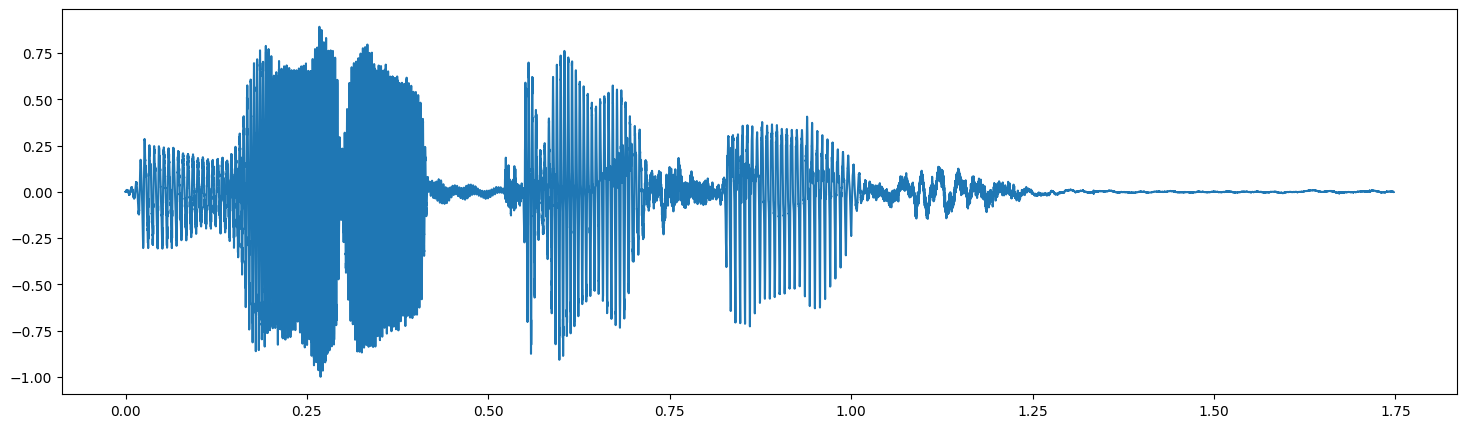

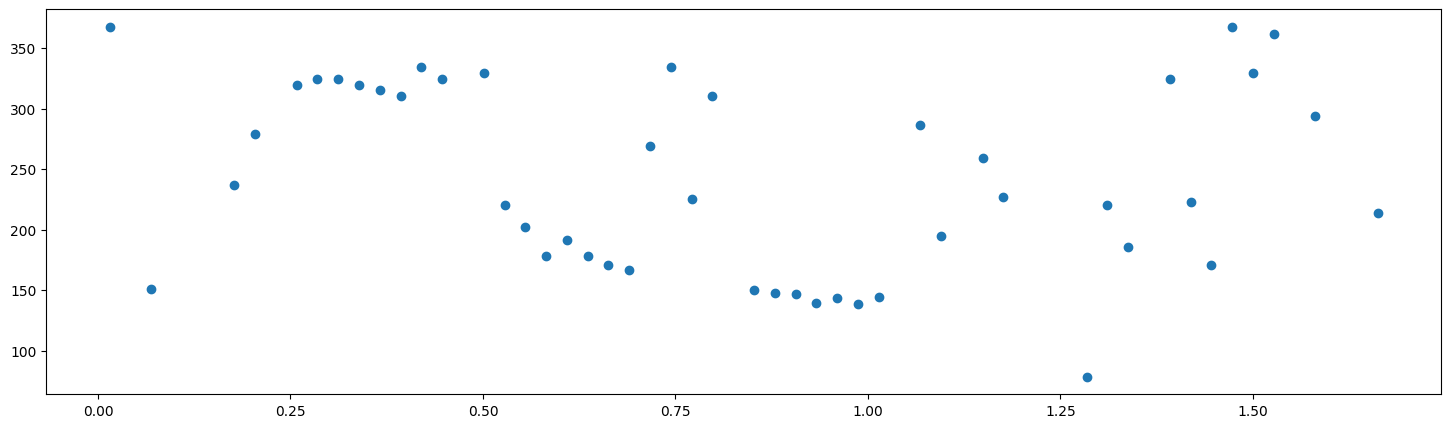

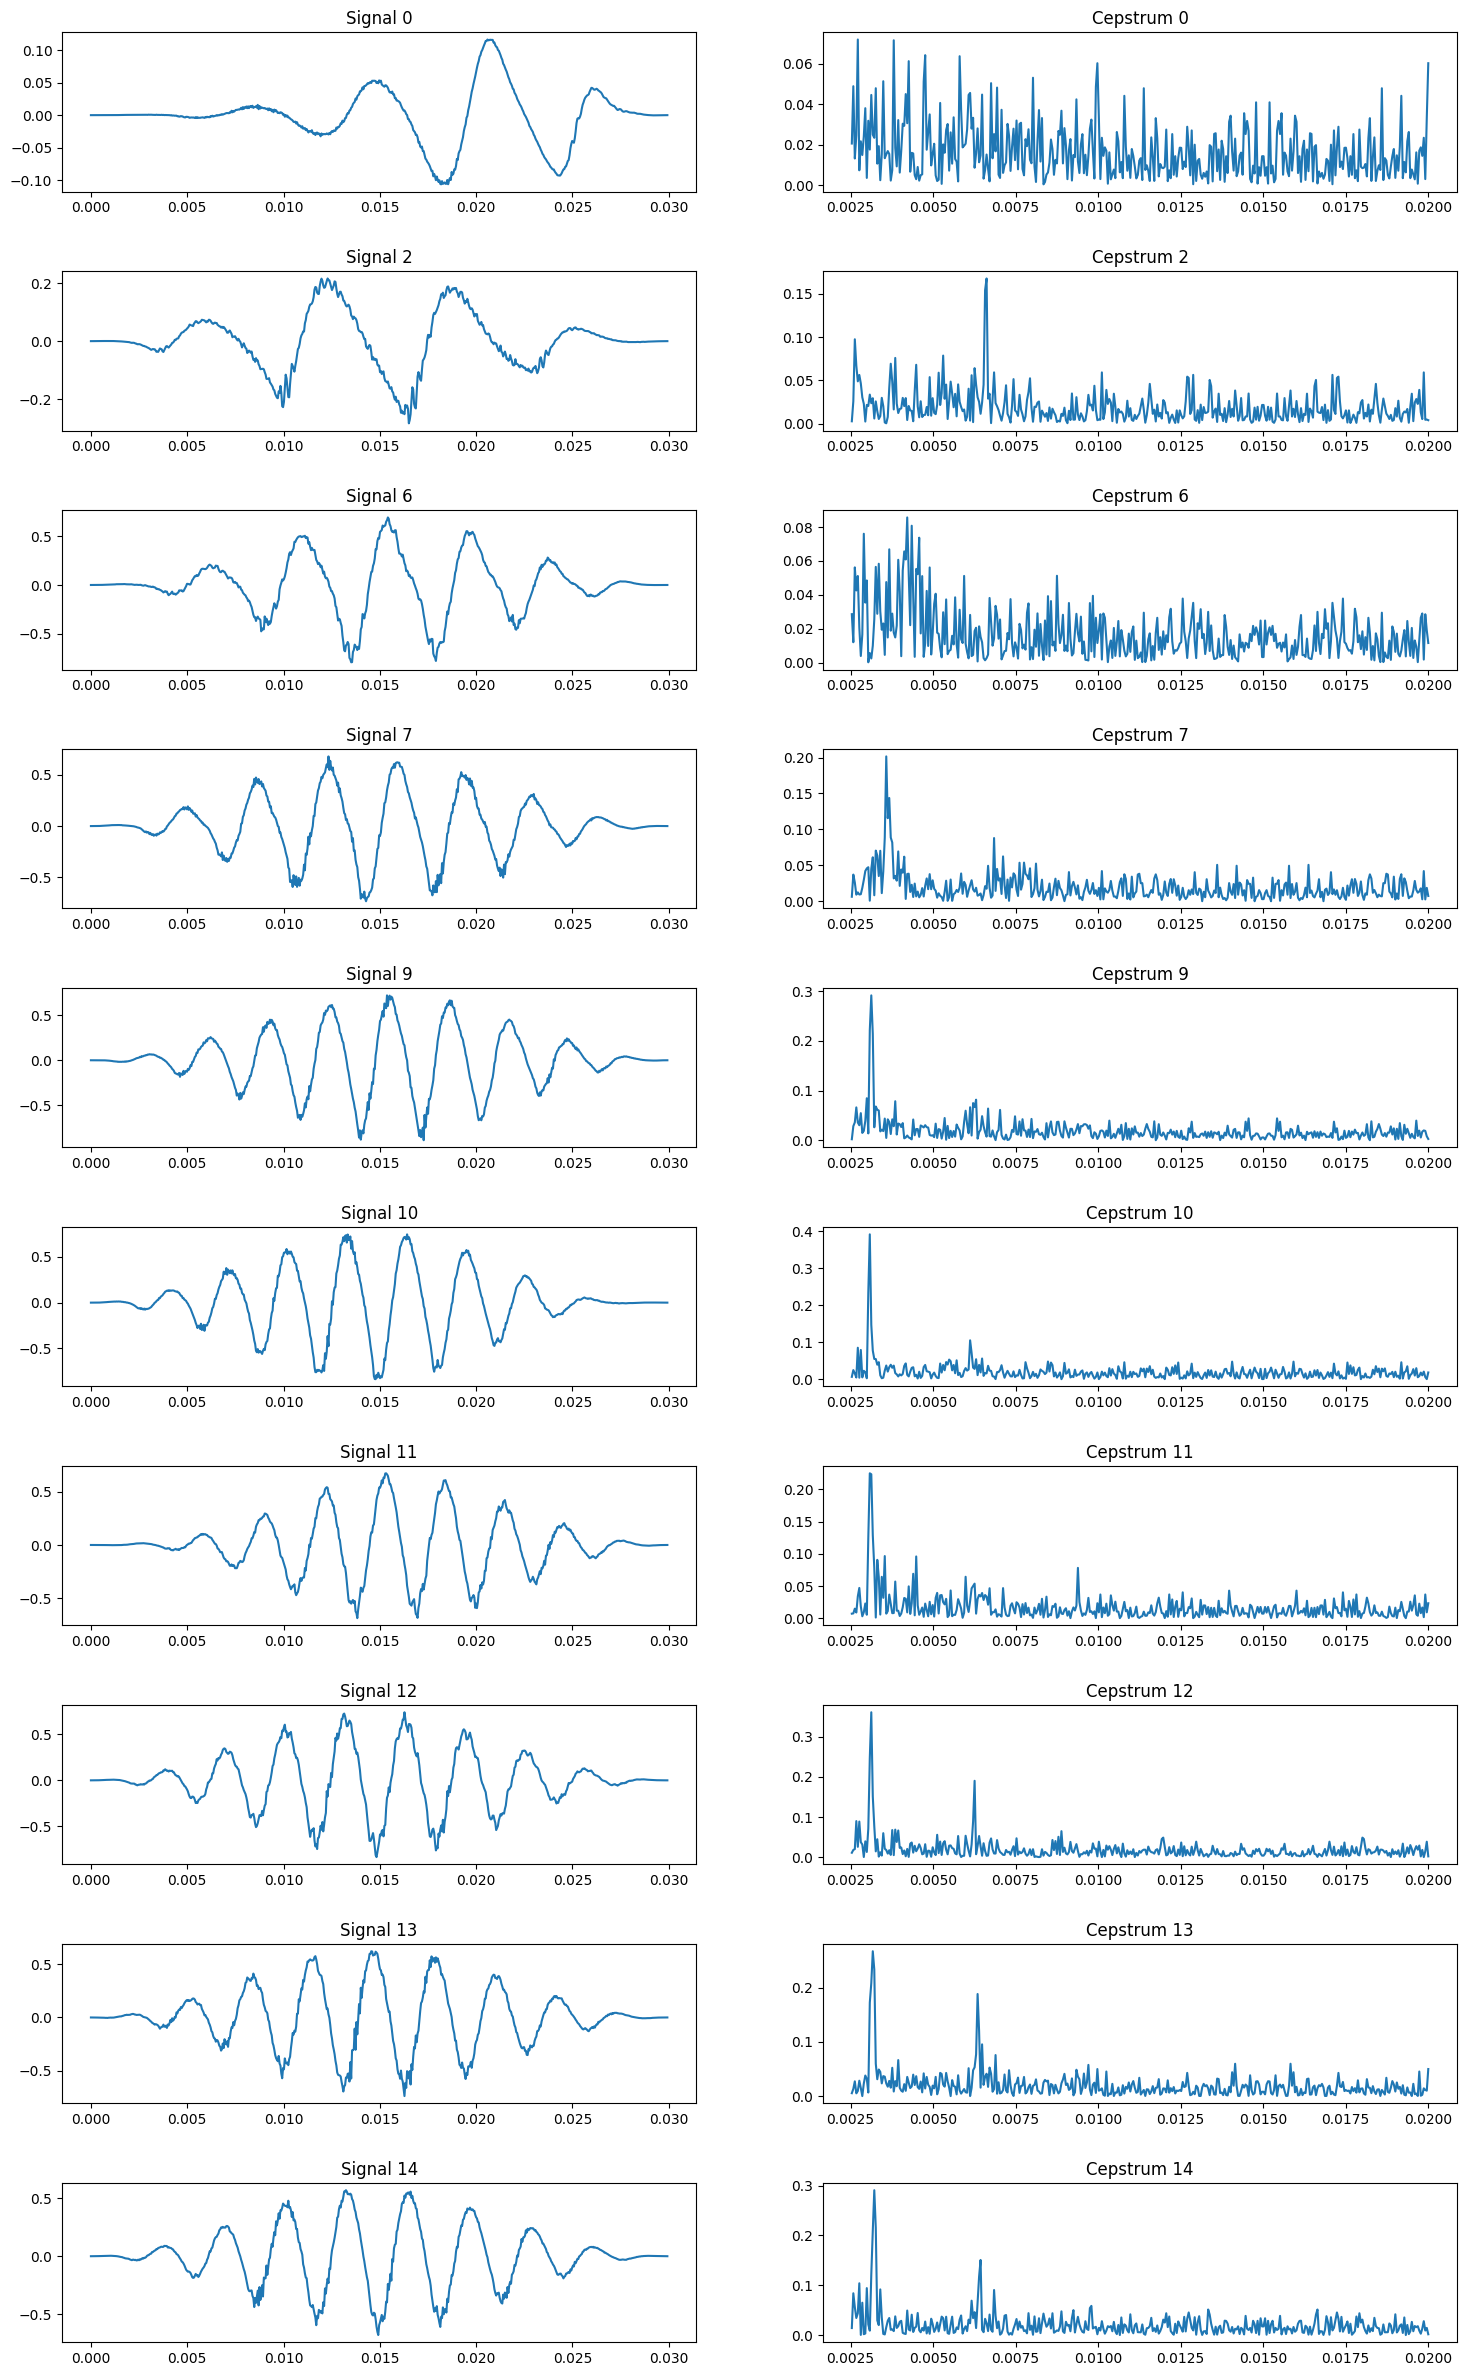

In [231]:
import scipy.io.wavfile as wavfile

WINDOW_SIZE_SEC = 0.03 # 30ms
WINDOW_OVERLAP_PCT = 0.1 # 10%

sample_rate, sig = wavfile.read("cta0001.wav")

sig = np.array(sig)

# Нормализация
sig = sig/max(abs(sig));

# w= signal.windows.boxcar(math.floor(WINDOW_SIZE_SEC*sample_rate), sym)
w = signal.windows.hann(math.floor(WINDOW_SIZE_SEC*sample_rate))
# w = signal.windows.gaussian(math.floor(WINDOW_SIZE_SEC*sample_rate), 170)

plot_original_signal(sig, sample_rate)

# Compute Pitch
pitch = compute_pitch(sig, w, sample_rate, WINDOW_OVERLAP_PCT, WINDOW_SIZE_SEC, show_charts=True)
print(f'Estimated pitch (Hz): ', pitch)